# [복습 과제1] 2024년 9월 '야구' 관련 뉴스 본문 수집하기

1. 앞서 제시한 코드를 활용하여, '야구'분야 URL을 가지고 옵니다. 
2. 날짜 범위를 2024년 9월로 조정합니다.
3. '제목', '링크'에 추가로 '조회수'를 파싱해 리스트로 생성합니다.
4. `discipline_list` 리스트를 생성하고, 뉴스 길이만큼 'ARC'로 값을 채워 데이터 프레임에 컬럼을 하나 더 추가합니다.
5. 최종적으로 '제목', 'URL', '조회수', '날짜' 4개의 컬럼을 생성한 데이터프레임을 만들어 csv파일을 추출합니다. slack채널에는 데이터프레임 이미지를 캡처해 댓글로 업로드합니다.

In [1]:
!pip install selenium
!apt-get update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver '/content/drive/MyDrive/Colab Notebooks'
!pip install chromedriver-autoinstaller

zsh:1: command not found: apt-get
The operation couldn’t be completed. Unable to locate a Java Runtime.
Please visit http://www.java.com for information on installing Java.

cp: /usr/lib/chromium-browser/chromedriver: No such file or directory


In [2]:
# selenium 설치 확인

!python --version

import selenium
print(selenium.__version__)

Python 3.12.2
4.25.0


In [3]:
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
import sys
from selenium.webdriver.common.keys import Keys
import urllib.request
import os
from urllib.request import urlretrieve

import time
import pandas as pd
import chromedriver_autoinstaller  # setup chrome options

In [4]:
#  ChromeDriver를 자동으로 설치하고 경로를 반환합니다.
chrome_path = chromedriver_autoinstaller.install()  

In [5]:
sys.path.insert(0,chrome_path)
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless') # Colab은 새창을 지원하지않기 때문에 창을 띄우지 않는 Headless 모드로 실행해야 합니다.
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')  # set path to chromedriver as per your configuration
chrome_options.add_argument('lang=ko_KR') # 한국어

chromedriver_autoinstaller.install()  # set the target URL

'/opt/anaconda3/lib/python3.12/site-packages/chromedriver_autoinstaller/129/chromedriver'

In [6]:
# 셀레니움 라이브러리를 사용하여 Chrome 웹 브라우저를 자동으로 제어하기 위해
# ChromeDriver를 초기화하는 코드
driver = webdriver.Chrome(options=chrome_options)

In [7]:
# 링크
url = 'https://sports.news.naver.com/kbaseball/news/index?isphoto=N&type=popular'

# 드라이버로 URL 접속하기
driver.get(url)

In [8]:
# 드라이버에서 페이지 소스 코드 불러오기
html = driver.page_source

In [9]:
# BeautifulSoup 객체 생성
from bs4 import BeautifulSoup

soup = BeautifulSoup(html, 'html.parser')

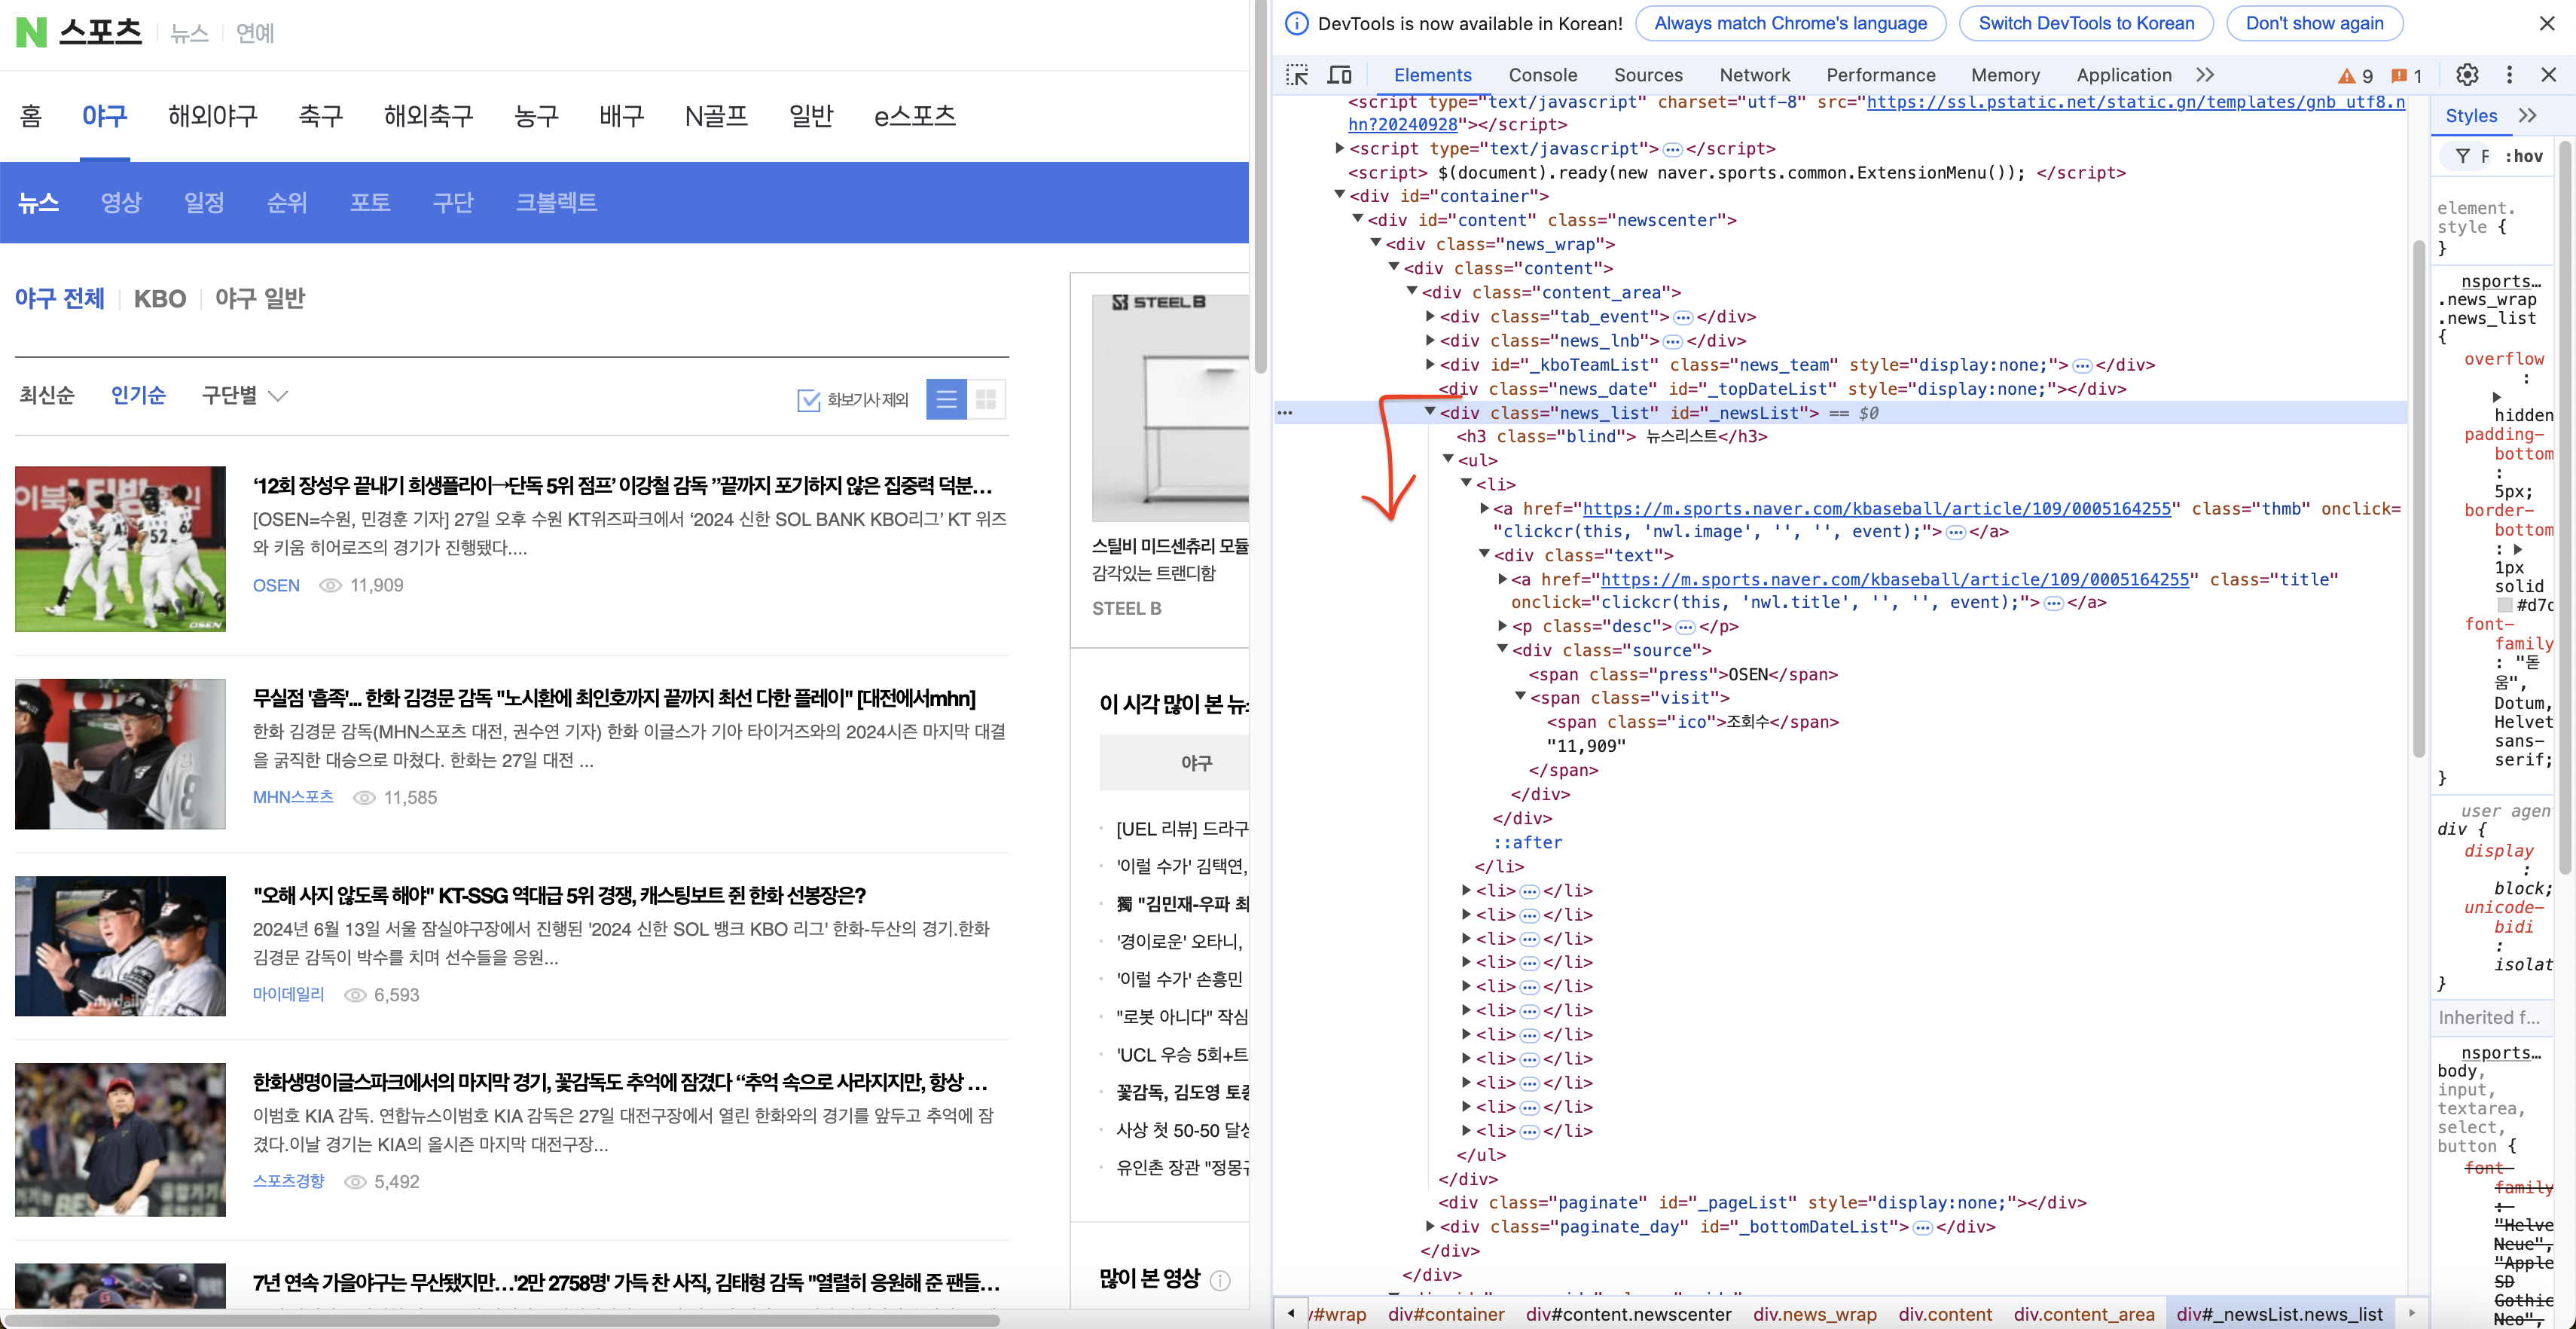

In [10]:
# 정규표현식 라이브러리
import re

# BeautifulSoup으로 뉴스 리스트 영역 설정
# re.compile('news_list') : 정규 표현식을 사용해 news_list 문자열을 포함하는 속성을 가진 요소를 찾도록 지시
# news_list는 클래스 이름이거나, ID와 같은 다른 속성으로 사용 가능
# => news_list라는 문자열이 포함된 속성을 가진 div태그를 찾는다

news_section = soup.find('div', re.compile('news_list'))

# 영역 내에서 뉴스 리스트 불러오기
# 이전 코드에서 찾은 div 태그가 news_section에 있다. 
# news_section 내부의 li태그 찾기
# news_tag_list는 news_section 안에 있는 li태그의 리스트
news_tag_list = news_section.find_all('li')
news_tag_list

[<li>
 <a class="thmb" href="https://m.sports.naver.com/kbaseball/article/109/0005164255" onclick="clickcr(this, 'nwl.image', '', '', event);">
 <img alt="‘12회 장성우 끝내기 희생플라이→단독 5위 점프’ 이강철 감독 ”끝까지 포기하지 않은 집중력 덕분에 승리” [오!쎈 수원]" class="lazyLoadImage" lazy-src="https://imgnews.pstatic.net/image/origin/109/2024/09/28/5164255.jpg?type=w140" src="https://imgnews.pstatic.net/image/origin/109/2024/09/28/5164255.jpg?type=w140" width="140"/>
 <span class="mask"></span>
 </a>
 <div class="text">
 <a class="title" href="https://m.sports.naver.com/kbaseball/article/109/0005164255" onclick="clickcr(this, 'nwl.title', '', '', event);"><span>‘12회 장성우 끝내기 희생플라이→단독 5위 점프’ 이강철 감독 ”끝까지 포기하지 않은 집중력 덕분에 승리” [오!쎈 수원]</span></a>
 <p class="desc">[OSEN=수원, 민경훈 기자] 27일 오후 수원 KT위즈파크에서 ‘2024 신한 SOL BANK KBO리그’ KT 위즈와 키움 히어로즈의 경기가 진행됐다....</p>
 <div class="source">
 <span class="press">OSEN</span>
 <span class="visit"><span class="ico">조회수</span>27,705</span>
 </div>
 </div>
 </li>,
 <li>
 <a class="thmb" href="htt

In [11]:
# 뉴스 제목 리스트 만들기
# x는 li태그
# li 태그 내부에서 title이라는 문자열을 포함하는 a태그를 찾는 작업 수행
news_title = list(map(lambda x : x.find('a', re.compile('title')).text, news_tag_list))
news_title

['‘12회 장성우 끝내기 희생플라이→단독 5위 점프’ 이강철 감독 ”끝까지 포기하지 않은 집중력 덕분에 승리” [오!쎈 수원]',
 '무실점 \'흡족\'... 한화 김경문 감독 "노시환에 최인호까지 끝까지 최선 다한 플레이"  [대전에서mhn]',
 "'장성우 연장 12회 짜릿한 끝내기' kt, SSG에 0.5게임 앞선 5위",
 '[강호철의 스포트S라이트] “대부분 선수들처럼 내가 은퇴 결정 못해 마운드가 더 그립다”',
 '"오해 사지 않도록 해야" KT-SSG 역대급 5위 경쟁, 캐스팅보트 쥔 한화 선봉장은?',
 '‘출루머신’ LG 홍창기, 타율까지 개인 최고 시즌',
 '7년 연속 가을야구는 무산됐지만…\'2만 2758명\' 가득 찬 사직, 김태형 감독 "열렬히 응원해 준 팬들께 감사" [MD부산]',
 '114일 만의 선발승...한현희는 벌써 2025년 의욕 폭발 "선발 준비 잘해서 자리 잡겠다" [오!쎈 부산]',
 '한화생명이글스파크에서의 마지막 경기, 꽃감독도 추억에 잠겼다 “추억 속으로 사라지지만, 항상 기억될 것”[스경X현장]',
 '[오늘의 야구장 날씨] 늦어위에 비소식...큰 일교차',
 "장성우 연장 12회 '끝내기'...kt, 5위 싸움 '끝까지'",
 '우승팀을 8-0으로 꺾다니…7위 지킨 한화, 40-40 도전 김도영 침묵시켰다 "와이스 완벽한 피칭"',
 "'레이예스 시즌 199안타' 롯데는 NC에 13:6 대승",
 'KS 직행팀 상대 \'3안타 맹타\' 한화 노시환 "팀 승리가 더 기뻐"[대전 히어로]',
 'KBO, WBSC 프리미어12 원정 응원단 운영 대행 업체 선정 입찰 공고',
 "ABS 시대에도 변함 없는 '출루왕' 홍창기",
 '류현진, 한화 복귀 첫 시즌 10승·평균자책점 3.87로 마무리',
 '새로운 팀으로 거듭난 LG, "우승 위한 과감한 결단"',
 "'롯태현' 3억 도장 쾅! 롯데, 신인 10명과 8.7억에 계약 완료...27일 '루키 데이' 마쳐",
 '삼성, 드래프트 1라운드 투수 배찬승과 4억 

In [12]:
# 뉴스 속성 리스트 만들기 - 링크들
# thmb라는 문자열이 포함된 a태그 찾기 -> 뉴스 썸네일 이미지 링크
# 해당 a태그에서 href 속성 값 갖고오기 -> 링크 url 나타낸다. 
news_link = list(map(lambda x : x.find('a', re.compile('thmb')).get('href'), news_tag_list))
news_link

['https://m.sports.naver.com/kbaseball/article/109/0005164255',
 'https://m.sports.naver.com/kbaseball/article/445/0000239603',
 'https://m.sports.naver.com/kbaseball/article/472/0000032741',
 'https://m.sports.naver.com/kbaseball/article/023/0003861031',
 'https://m.sports.naver.com/kbaseball/article/117/0003874899',
 'https://m.sports.naver.com/kbaseball/article/020/0003589613',
 'https://m.sports.naver.com/kbaseball/article/117/0003874898',
 'https://m.sports.naver.com/kbaseball/article/109/0005164256',
 'https://m.sports.naver.com/kbaseball/article/144/0000991213',
 'https://m.sports.naver.com/kbaseball/article/410/0001025927',
 'https://m.sports.naver.com/kbaseball/article/052/0002092923',
 'https://m.sports.naver.com/kbaseball/article/109/0005164250',
 'https://m.sports.naver.com/kbaseball/article/472/0000032743',
 'https://m.sports.naver.com/kbaseball/article/076/0004198045',
 'https://m.sports.naver.com/kbaseball/article/445/0000239646',
 'https://m.sports.naver.com/kbaseball/a

In [13]:
# 조회수 파싱
news_hits = list(map(lambda x : x.find('span', re.compile('visit')).get_text(), news_tag_list))
news_hits

['조회수27,705',
 '조회수25,895',
 '조회수17,191',
 '조회수11,926',
 '조회수10,472',
 '조회수8,221',
 '조회수7,609',
 '조회수7,354',
 '조회수6,702',
 '조회수3,286',
 '조회수3,015',
 '조회수2,945',
 '조회수1,872',
 '조회수1,523',
 '조회수556',
 '조회수487',
 '조회수311',
 '조회수211',
 '조회수55',
 '조회수41']

In [14]:
# 날짜 범위 계산하기
date_range = pd.date_range('2024-09-01', '2024-09-27').strftime('%Y%m%d')
date_range

Index(['20240901', '20240902', '20240903', '20240904', '20240905', '20240906',
       '20240907', '20240908', '20240909', '20240910', '20240911', '20240912',
       '20240913', '20240914', '20240915', '20240916', '20240917', '20240918',
       '20240919', '20240920', '20240921', '20240922', '20240923', '20240924',
       '20240925', '20240926', '20240927'],
      dtype='object')

In [15]:
from tqdm.auto import tqdm

total_news_list = []
for date in tqdm(date_range):
    url = f'https://sports.news.naver.com/kbaseball/news/index?isphoto=N&type=popular&date={date}'
    driver.get(url)
    time.sleep(2)
    
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')
    
    news_section = soup.find('div', re.compile('news_list'))
    news_tag_list = news_section.find_all('li')
    
    news_title = list(map(lambda x : x.find('a', re.compile('title')).text, news_tag_list))
    news_link = list(map(lambda x : x.find('a', re.compile('thmb')).get('href'), news_tag_list))
    news_hits = list(map(lambda x : x.find('span', re.compile('visit')).get_text(), news_tag_list))


    date_list = [date] * len(news_link)
    
    daily_news_list = list(zip(news_title, news_link, date_list, news_hits))
    total_news_list.extend(daily_news_list)

  0%|          | 0/27 [00:00<?, ?it/s]

In [16]:
df = pd.DataFrame(total_news_list, columns = ['title', 'url', 'date', 'hits'])
df

,title,url,date,hits
0,"'김도영 35호포→나성범 동점포→이우성 9회 결승타' 0-5 뒤집은 KIA, 챔피언...",https://m.sports.naver.com/kbaseball/article/0...,20240901,"조회수139,376"
1,"'초비상' 롯데, 팀 최다 홈런 손호영 사구 후 교체...149km 직구 오른손 강...",https://m.sports.naver.com/kbaseball/article/3...,20240901,"조회수131,960"
2,“진짜 말도 안 되는 인생 홈런” 스리런 포함 3안타 5타점 먹방쇼→15-13 승리...,https://m.sports.naver.com/kbaseball/article/1...,20240901,"조회수125,209"
3,"‘예외 없다’ KIA, 2위 삼성 연파하고 6.5게임 차 선두…매직넘버 12",https://m.sports.naver.com/kbaseball/article/1...,20240901,"조회수122,346"
4,"한화이글스, 올해도 가을 야구는 멀어지나",https://m.sports.naver.com/kbaseball/article/6...,20240901,"조회수114,159"
...,...,...,...,...
515,"[공식] 배찬승 4억-구단 역대 2위→원태인보다 많다, 삼성 2025 신인 계약…심...",https://m.sports.naver.com/kbaseball/article/4...,20240927,"조회수62,457"
516,"김도영, 와이스→반즈→하트? 왜 외인 에이스만 계속 만나나…'토종 최초 40-40'...",https://m.sports.naver.com/kbaseball/article/3...,20240927,"조회수61,783"
517,"'MVP 예약' KIA 김도영→오늘(27일) 홈런 기대감 높은 이유, 드디어 다시 ...",https://m.sports.naver.com/kbaseball/article/1...,20240927,"조회수59,023"
518,"'미친 폭염' 혼난 KBO, 2025시즌 7·8월 일요일·공휴일 오후 6시 개시 변...",https://m.sports.naver.com/kbaseball/article/3...,20240927,"조회수58,587"


In [17]:
import os

path = '/Users/ranny/GDSC EWHA/'
file_name = f'프로야구_네이버_뉴스_{date_range[0]}_{date_range[-1]}.csv'

df.to_csv(os.path.join(path, file_name), index=False)